In [1]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re
import os

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

C:\Users\edufe\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Abre os dados

In [2]:
#Verifica os dados no diretorio

Data = os.listdir("../Filter/Tweets_Filtered/")
for i in range(len(Data)):
    Data[i] = Data[i].split(".")[0]
    
Pessoas = ["realDonaldTrump", "jairbolsonaro", "hbredda", "gui_benchimol", "pedrocerize"]

NoticiasPolitica = ["OGloboPolitica", "folha_poder", "GloboNews", "EstadaoPolitica", 
                    "RevistaEpoca", "valoreconomico", "g1politica", "conexaopolitica", "EstadaoEconomia", 
                    "UOLEconomia", "folha_mercado", "g1economia", "OGlobo_Economia"]

Noticias = ["UOL", "folha", "g1", "VEJA", "cartacapital", "RevistaISTOE"]

#Monta um dicionario com todos datasets de twites de todas as pessoas
Alvo = NoticiasPolitica


AllData = pd.DataFrame()
for i in Alvo:
    if i in Data:
        MoreData = pd.read_csv("../Filter/Tweets_Filtered/{0}".format(i+".csv"), sep=";", decimal=",", encoding='utf-16')
        AllData = pd.concat([AllData, MoreData])
    else:
        print("{0} não disponivel".format(i))
        
AllData = AllData.reset_index(drop=True)

In [3]:
label_encoder = LabelEncoder()

label_encoder.fit(AllData.Pessoa)
AllData['Pessoa_id'] = label_encoder.transform(AllData.Pessoa)

In [4]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id
16842,valoreconomico,2019-04-02 13:35:30,inep mantém cronograma do enem mesmo após falê...,3,13,1,12
22806,conexaopolitica,2019-04-06 13:44:37,lidas da semana brasil e israel firmam 6 acor...,57,365,1,7
17240,valoreconomico,2019-03-25 19:40:27,o desafio dos preços moderados das commodities...,5,18,1,12
29452,UOLEconomia,2019-03-27 13:04:00,eduardo bolsonaro vota pela pec do orçamento n...,1,4,1,6
8747,GloboNews,2019-02-27 14:15:19,rt murilosalviano antes do carnaval aqueciment...,10,0,0,2


In [5]:
document_lengths = np.array(list(map(len, AllData.Texto.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 13.991752676762806.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 30.


In [6]:
#Remove os Tweets com compriento menor que 4 palavras
smallerthen4 = document_lengths <= 5

for i in range(len(document_lengths)):
    if smallerthen4[i]:
        AllData = AllData.drop(i)

document_lengths = np.array(list(map(len, AllData.Texto.str.split(' '))))

AllData = AllData.reset_index(drop=True)

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['document_sentences'] = df.Texto.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(sentences),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(AllData)

## Word2Vec

In [9]:
sentences = []
for sentence_group in AllData.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(AllData)))

Number of sentences: 41073.
Number of texts: 41073.


In [10]:
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 11       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

In [11]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

AllData['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      AllData.tokenized_sentences))

C:\Users\edufe\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [12]:
w2vec_distribution = []
for i in Alvo:
    w2vec_distribution.append(AllData.loc[AllData.Pessoa == i, 'w2v_features'].mean())

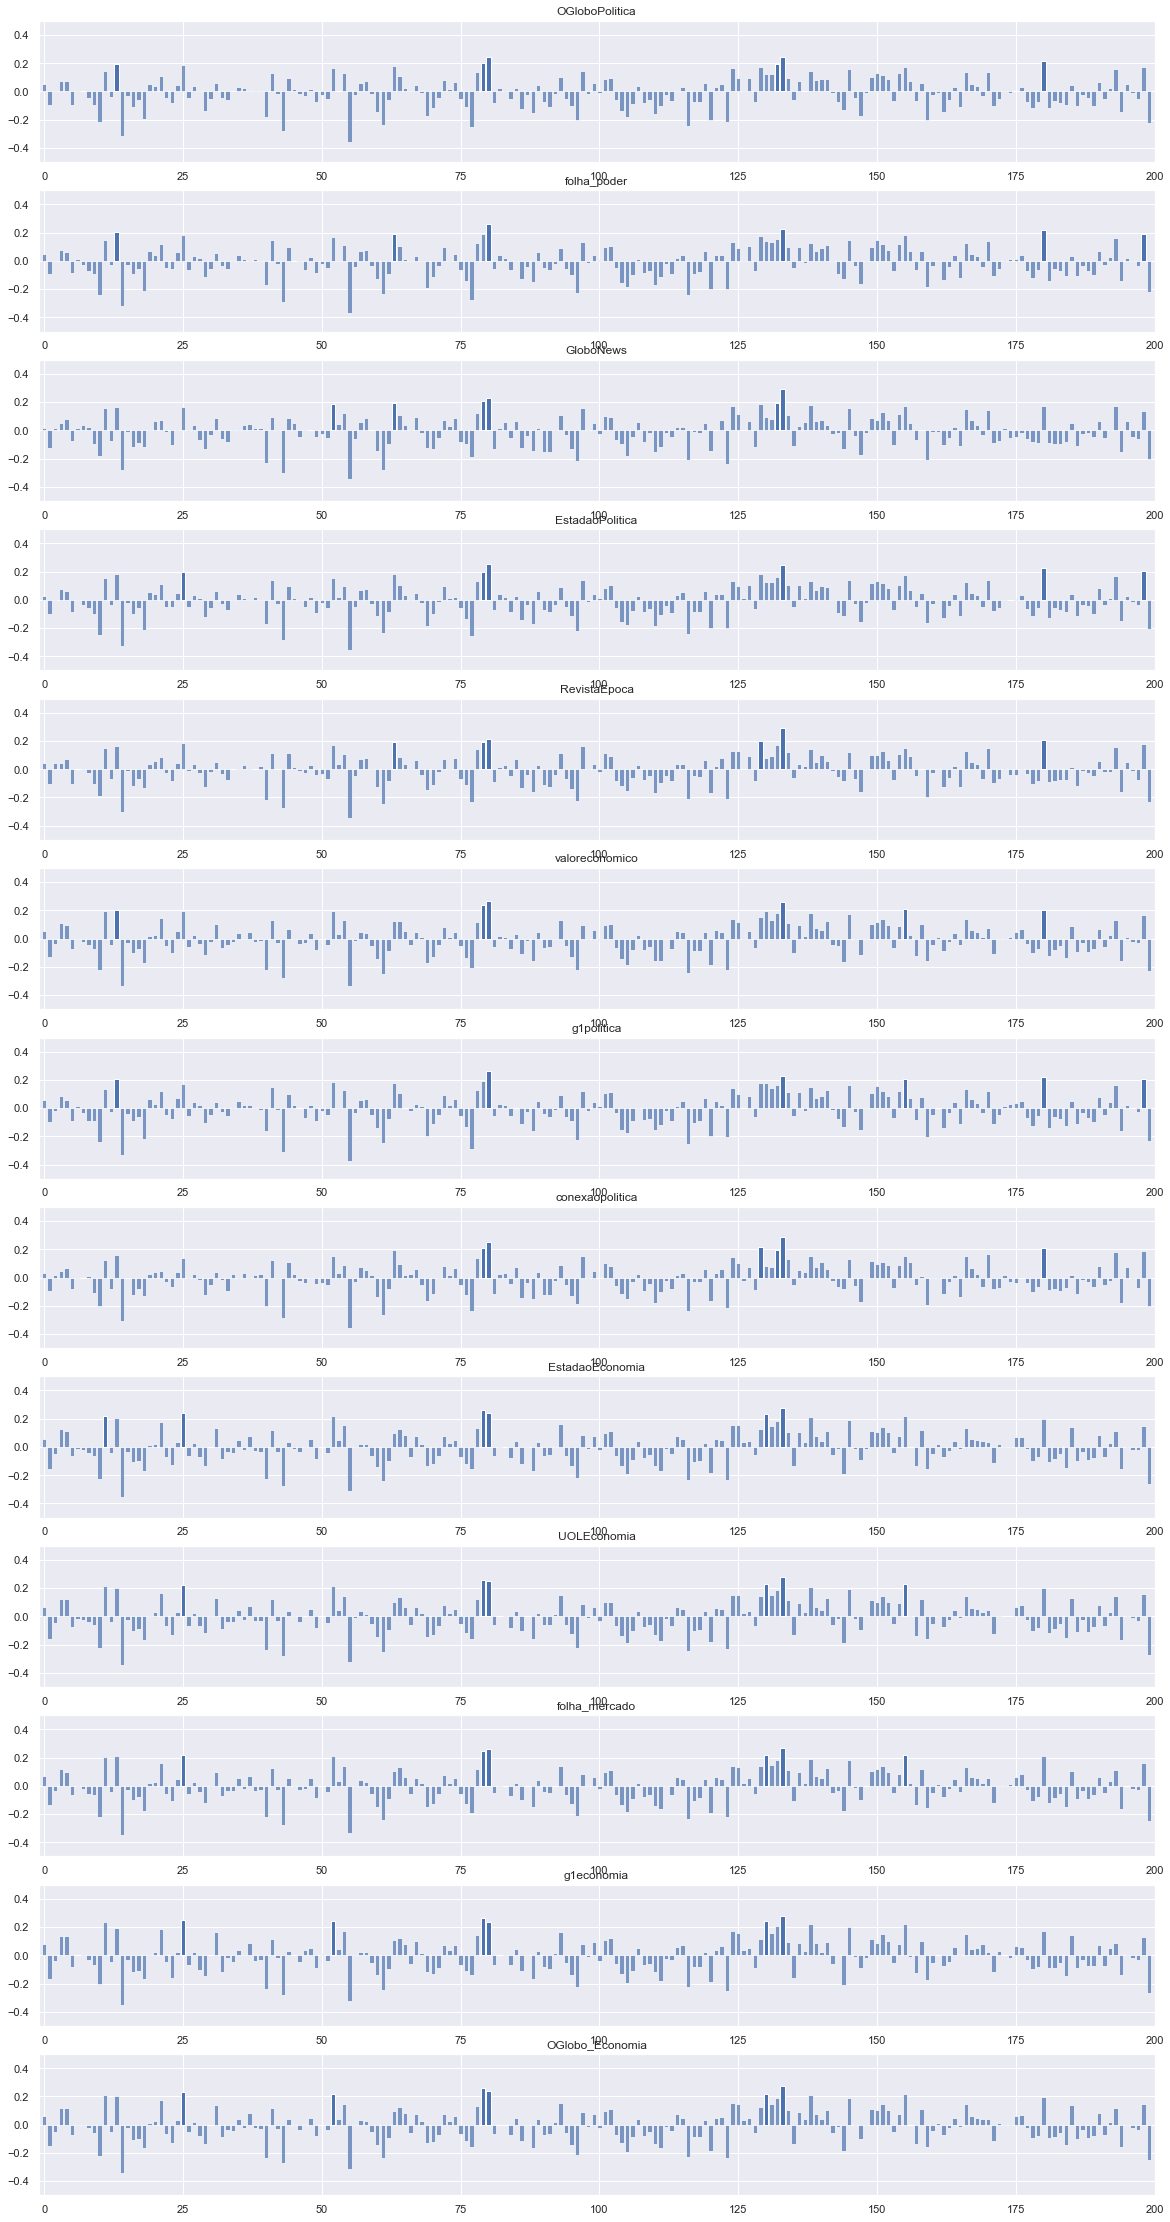

In [13]:
ax = 0

Axes = [ax]*len(Alvo)
fig, Axes = plt.subplots(len(Alvo),figsize=(20,40))

nr_top_bars = 6

for i in range(len(Axes)):
    Axes[i].set_title(Alvo[i])

for ax, distribution in zip(Axes, w2vec_distribution):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, num_features)
    ax.set_ylim(-0.5,0.5)

## Tester

In [26]:
list(W2Vmodel.wv.vocab)[:100]

['carlos',
 'ignora',
 'ponto',
 'final',
 'do',
 'pai',
 'e',
 'volta',
 'a',
 'atacar',
 'mourão',
 'alinhamento',
 'com',
 'políticos',
 'que',
 'o…',
 'polícia',
 'civil',
 'deflagra',
 'operação',
 'em',
 'todo',
 'o',
 'país',
 'contra',
 'foragidos',
 'da',
 'justiça',
 'análise',
 'decisão',
 'stj',
 'sobre',
 'lula',
 'não',
 'muda',
 'situação',
 'pt',
 'bom',
 'dia',
 'leitor',
 'siga',
 'aqui',
 'as',
 'principais',
 'notícias',
 'política',
 'nacional',
 'os',
 'acontecimentos',
 'mais',
 'importantes',
 'pelo',
 'pa…',
 'pode',
 'ser',
 'solto',
 'após',
 'entenda',
 'advogado',
 'de',
 'promete',
 'apresentar',
 'todos',
 'recursos',
 'lei',
 'permite',
 'para',
 'lo',
 'funcionário',
 'vale',
 'diz',
 'diretores',
 'riscos',
 'barragem',
 'brumadinho',
 'bolsonaro',
 'quer',
 'briga',
 'entre',
 'mas',
 'filho',
 'estará',
 'sempre',
 'ao',
 'seu',
 'lado',
 '…',
 '“',
 'esperava',
 'nada',
 'positivo',
 'julgamento',
 '”',
 'disse',
 'lulaoficial',
 'aliado',
 'quando'

In [48]:
W2Vmodel.wv.most_similar("doria")

[('skaf', 0.8095237612724304),
 ('frança', 0.7996515035629272),
 ('jdoriajr', 0.7893561720848083),
 ('márcio', 0.781616747379303),
 ('covas', 0.7785654664039612),
 ('alckmin', 0.7651681900024414),
 ('joão', 0.7536182403564453),
 ('amoêdo', 0.7510025501251221),
 ('empatados', 0.7364290356636047),
 ('secretários', 0.7320196628570557)]

In [50]:
W2Vmodel.predict_output_word(["prefeito", "são", "paulo", "eleição"])

[('paulo', 0.0012864138),
 ('são', 0.00085928565),
 ('joão', 0.0007867645),
 ('bernardo', 0.0007471371),
 ('governador', 0.0005714589),
 ('neto', 0.00057021814),
 ('fernando', 0.00053237163),
 ('guedes', 0.0005098263),
 ('prefeito', 0.00048787284),
 ('vivo', 0.00048302847)]